[캐글] https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
- 2가지 방법으로 구현해보고자 한다.

# 방법1

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import pathlib
import splitfolders

import PIL
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

## 데이터 로드

In [2]:
for root, dirs, file in os.walk("data/image/images/"):
    print(root, dirs, len(file))

data/image/images/ [] 809


In [3]:
img = glob.glob('data/image/images/*')
img = pd.Series(img)
img[:5]

0          data/image/images\abomasnow.png
1               data/image/images\abra.png
2              data/image/images\absol.png
3           data/image/images\accelgor.png
4    data/image/images\aegislash-blade.png
dtype: object

In [4]:
img_df = pd.DataFrame()
img_df["file_name"] = img.map(lambda x:x.split("\\")[-1])
img_df.head()

,file_name
0,abomasnow.png
1,abra.png
2,absol.png
3,accelgor.png
4,aegislash-blade.png


## 이미지 미리보기

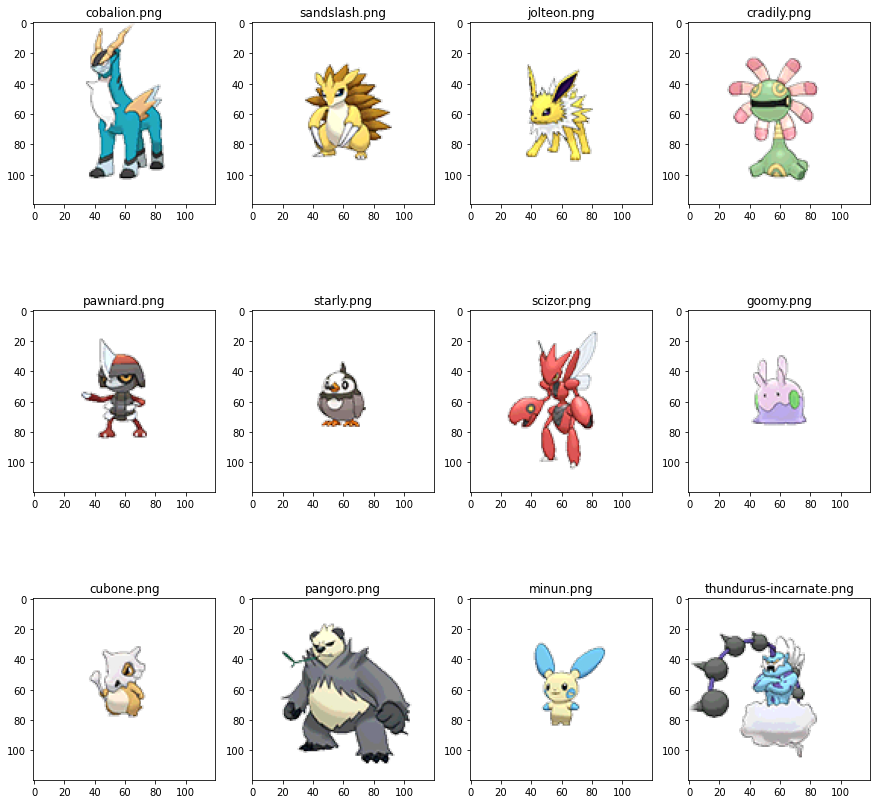

In [5]:
plot_df = img_df.sample(12).reset_index()
plt.figure(figsize = (15,15))

for _ in range(12):
    img_name = plot_df.loc[_,"file_name"]
    plt.subplot(3,4,_+1)
    plt.imshow(plt.imread(os.path.join("data/image/images",img_name)))
    plt.title(img_name)

In [6]:
# 이미지 사이즈
image_0 = img[0]
image_0_img = plt.imread(image_0)
print(image_0_img.shape)

(120, 120, 4)


## 학습 데이터 준비

In [7]:
total_df = pd.read_csv("data/pokemon.csv")
total_df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [8]:
# 경로 추가
total_df["path"] = img
total_df.head()

,Name,Type1,Type2,path
0,bulbasaur,Grass,Poison,data/image/images\abomasnow.png
1,ivysaur,Grass,Poison,data/image/images\abra.png
2,venusaur,Grass,Poison,data/image/images\absol.png
3,charmander,Fire,NaN,data/image/images\accelgor.png
4,charmeleon,Fire,NaN,data/image/images\aegislash-blade.png


In [9]:
# 유형 분포 확인하기
distribution = total_df["Type1"].value_counts(1)
total_df["Type1"].value_counts(0)

Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: Type1, dtype: int64

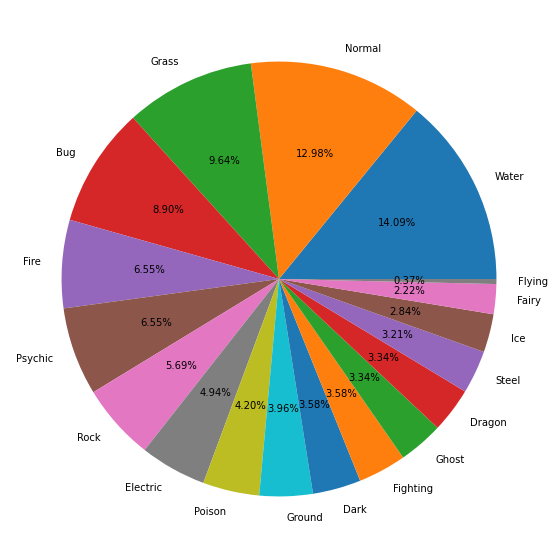

In [10]:
plt.figure(facecolor="white", figsize = (10,10))
_ = plt.pie(x = distribution.values, labels = distribution.index, autopct= "%.2f%%")
plt.show()

In [11]:
poke_type = []
code = []

for i in range(total_df.shape[0]):
    if (total_df.iloc[i]['Type1']=='Grass') or (total_df.iloc[i]['Type2']=='Grass'):
        poke_type.append('Grass')
        code.append(1)
    elif (total_df.iloc[i]['Type1']=='Water') or (total_df.iloc[i]['Type2']=='Water'):
        poke_type.append('Water')
        code.append(2)
    elif (total_df.iloc[i]['Type1']=='Fire') or (total_df.iloc[i]['Type2']=='Fire'):
        poke_type.append('Fire')
        code.append(3)
    else:
        poke_type.append('NaN')
        code.append('NaN')

In [12]:
total_df['type'] = poke_type
total_df['code'] = code

final_df = total_df.drop(columns = ["Type1", "Type2"], axis = 1)
final_df = final_df[final_df['type'] != "NaN"]
final_df.reset_index(drop = True, inplace = True)

final_df

,Name,path,type,code
0,bulbasaur,data/image/images\abomasnow.png,Grass,1
1,ivysaur,data/image/images\abra.png,Grass,1
2,venusaur,data/image/images\absol.png,Grass,1
3,charmander,data/image/images\accelgor.png,Fire,3
4,charmeleon,data/image/images\aegislash-blade.png,Fire,3
...,...,...,...,...
283,dhelmise,data/image/images\wigglytuff.png,Grass,1
284,tapu-bulu,data/image/images\wooper.png,Grass,1
285,tapu-fini,data/image/images\wormadam-plant.png,Water,2
286,kartana,data/image/images\yveltal.png,Grass,1


<AxesSubplot:xlabel='type', ylabel='count'>

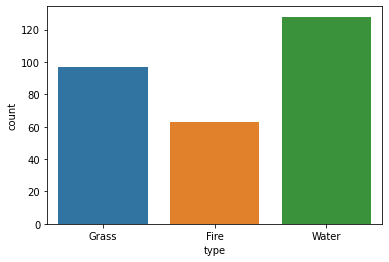

In [13]:
sns.countplot(data = final_df, x = "type")

### imageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(
    
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1
)

### 학습 데이터 셋

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    final_df, 
    x_col='path', y_col='type',
    target_size=(120, 120), 
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training'
)

Found 260 validated image filenames belonging to 3 classes.


In [16]:
train_generator.class_indices

{'Fire': 0, 'Grass': 1, 'Water': 2}

### 검증 데이터 셋

In [17]:
validation_generator = train_datagen.flow_from_dataframe(
    final_df , x_col='path', y_col='type',
    target_size=(120, 120),
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 28 validated image filenames belonging to 3 classes.


In [18]:
validation_generator.class_indices

{'Fire': 0, 'Grass': 1, 'Water': 2}

## 모델링

In [30]:
model = Sequential()

# 입력층
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                activation = "selu", input_shape=(120,120,4)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2), strides = 1))

model.add(Conv2D(128, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.3))

# fully-connected layer
model.add(Flatten())
model.add(Dense(units = 64, activation = "selu"))

# 출력층
model.add(Dense(3, activation = "softmax", kernel_initializer='he_normal'))

In [31]:
# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 118, 64)      2368      
                                                                 
 batch_normalization_4 (Batc  (None, 118, 118, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 117, 117, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 115, 115, 128)     73856     
                                                                 
 batch_normalization_5 (Batc  (None, 115, 115, 128)    512       
 hNormalization)                                                 
                                                      

In [32]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
early_stop = EarlyStopping(monitor='val_accuracy', mode = "max", patience=20)

In [34]:
history = model.fit(train_generator, epochs = 100, validation_data = validation_generator, 
                    verbose = 1,callbacks = [early_stop])

Epoch 1/100
9/9 [==============================] - 9s 910ms/step - loss: 9.7279 - accuracy: 0.3885 - val_loss: 6.4552 - val_accuracy: 0.3214
Epoch 2/100
9/9 [==============================] - 8s 889ms/step - loss: 2.1910 - accuracy: 0.3885 - val_loss: 1.4371 - val_accuracy: 0.3571
Epoch 3/100
9/9 [==============================] - 8s 999ms/step - loss: 1.5867 - accuracy: 0.3577 - val_loss: 1.5012 - val_accuracy: 0.3571
Epoch 4/100
9/9 [==============================] - 8s 890ms/step - loss: 1.2716 - accuracy: 0.4423 - val_loss: 1.6860 - val_accuracy: 0.3571
Epoch 5/100
9/9 [==============================] - 8s 890ms/step - loss: 1.5477 - accuracy: 0.3846 - val_loss: 1.5269 - val_accuracy: 0.4286
Epoch 6/100
9/9 [==============================] - 8s 891ms/step - loss: 1.2011 - accuracy: 0.4385 - val_loss: 1.0693 - val_accuracy: 0.4286
Epoch 7/100
9/9 [==============================] - 8s 891ms/step - loss: 1.1577 - accuracy: 0.4154 - val_loss: 1.2059 - val_accuracy: 0.3214
Epoch 8/100
9

In [35]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
20,1.061274,0.438462,3.476736,0.357143
21,1.049401,0.419231,2.085765,0.285714
22,1.060587,0.442308,3.164349,0.285714
23,1.051743,0.469231,1.671748,0.321429
24,1.057000,0.457692,2.352297,0.178571


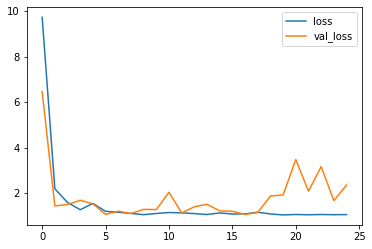

In [36]:
_ = df_hist[["loss", "val_loss"]].plot()

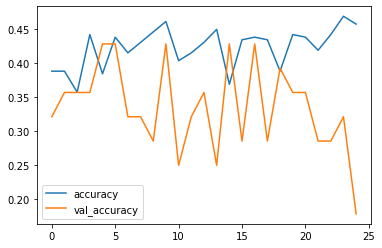

In [37]:
_ = df_hist[["accuracy", "val_accuracy"]].plot()

높은 정확도는 아니지만 loss와 val loss의 추이가 얼추 비슷하다.

[참고]
- https://www.kaggle.com/code/sanjanabhute03/pokemon-classifier-cnn-dl
- https://www.kaggle.com/code/shubhamptrivedi/pokemon-classification-model-using-tensorflow

# 방법 2

## 학습에 사용할 데이터 준비하기

In [51]:
root_dir = "data/image/images/"
files =  os.path.join(root_dir)
file_name = os.listdir(files)

In [52]:
df = pd.read_csv("data/pokemon.csv")
df = df.drop(columns = "Type2")
display(df.head())
df.shape

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire


(809, 2)

In [53]:
print(df.nunique())
df["Type1"].unique()

Name     809
Type1     18
dtype: int64


array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [54]:
data_dict = {}

for key, val in zip(df["Name"], df["Type1"]):
    data_dict[key] = val

In [55]:
label = ['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 
         'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 
         'Rock', 'Ghost', 'Ice','Dragon', 'Dark', 'Steel', 'Flying']

In [56]:
ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
label_idx = dict(zip(label,ids))

print(label_idx)

{'Grass': 0, 'Fire': 1, 'Water': 2, 'Bug': 3, 'Normal': 4, 'Poison': 5, 'Electric': 6, 'Ground': 7, 'Fairy': 8, 'Fighting': 9, 'Psychic': 10, 'Rock': 11, 'Ghost': 12, 'Ice': 13, 'Dragon': 14, 'Dark': 15, 'Steel': 16, 'Flying': 17}


In [57]:
# 최종 이미지와 라벨 만들기

final_images = []
final_labels = []
count = 0

for file in file_name:
    count += 1
    img = cv2.imread(os.path.join(root_dir, file), cv2.COLOR_BGR2GRAY)
    label = label_idx[data_dict[file.split(".")[0]]]
    
    final_images.append(np.array(img))
    final_labels.append(np.array(label))
    
final_images = np.array(final_images, dtype = np.float32) / 255.0
final_labels = np.array(final_labels, dtype = np.int8).reshape(809,1)

## 모델링

In [58]:
model = Sequential()

# 입력층
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = "valid",
                activation = "relu", input_shape=(120,120,3)))
model.add(MaxPool2D(pool_size = (2,2), strides = 1))
model.add(Dropout(0.2))

# fully-connected layer
model.add(Flatten())
model.add(Dense(units = 64, activation = "relu"))

# 출력층
model.add(Dense(18, activation = "softmax"))

In [59]:
# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 117, 117, 16)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 117, 117, 16)      0         
                                                                 
 flatten_3 (Flatten)         (None, 219024)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                14017600  
                                                                 
 dense_7 (Dense)             (None, 18)                1170      
                                                      

In [60]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=30)
history = model.fit(final_images, final_labels, validation_split = 0.3, epochs = 100, callbacks = early_stop)

Epoch 1/100
18/18 [==============================] - 3s 141ms/step - loss: 5.3777 - accuracy: 0.1113 - val_loss: 3.0511 - val_accuracy: 0.1358
Epoch 2/100
18/18 [==============================] - 2s 136ms/step - loss: 2.7070 - accuracy: 0.1731 - val_loss: 2.8024 - val_accuracy: 0.1440
Epoch 3/100
18/18 [==============================] - 2s 137ms/step - loss: 2.4574 - accuracy: 0.2173 - val_loss: 2.7509 - val_accuracy: 0.1687
Epoch 4/100
18/18 [==============================] - 2s 136ms/step - loss: 2.1716 - accuracy: 0.2809 - val_loss: 2.7695 - val_accuracy: 0.1523
Epoch 5/100
18/18 [==============================] - 2s 138ms/step - loss: 1.8195 - accuracy: 0.3869 - val_loss: 3.0963 - val_accuracy: 0.1523
Epoch 6/100
18/18 [==============================] - 3s 140ms/step - loss: 1.4136 - accuracy: 0.5495 - val_loss: 3.1043 - val_accuracy: 0.1317
Epoch 7/100
18/18 [==============================] - 2s 138ms/step - loss: 0.9455 - accuracy: 0.7261 - val_loss: 3.2850 - val_accuracy: 0.1399

In [62]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
28,0.020703,1.0,5.678334,0.156379
29,0.020021,1.0,5.753834,0.160494
30,0.017571,1.0,5.923148,0.160494
31,0.013785,1.0,6.082935,0.164609
32,0.011900,1.0,6.272846,0.164609


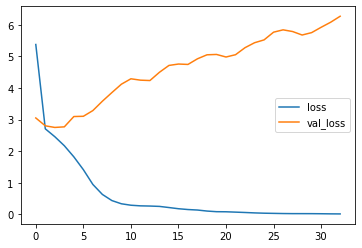

In [63]:
_ = df_hist[["loss", "val_loss"]].plot()

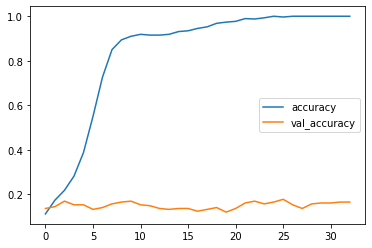

In [64]:
_ = df_hist[["accuracy", "val_accuracy"]].plot()

정확도가 높게 나온 반면 val의 점수는 매우 낮다.

[참고] https://www.kaggle.com/code/shubhamptrivedi/pokemon-classification-model-using-tensorflow